In [4]:
using TextAnalysis
using Random 
sampled_articles = readlines("wiki_20.txt")
# Tokenize and clean text
function preprocess(text)
    text = lowercase(text)
    tokens = filter(t -> length(t) > 1, split(replace(text, r"[^\w\s]" => " "), " "))  # Remove punctuation
    return tokens
end

# Preprocess all sampled articles
corpus = [preprocess(article) for article in sampled_articles]

20-element Vector{Vector{SubString{String}}}:
 ["the", "federalist", "papers", "is", "collection", "of", "articles", "and", "essays", "written"  …  "in", "the", "broadway", "musical", "hamilton", "written", "by", "lin", "manuel", "miranda"]
 ["centre", "county", "is", "county", "in", "the", "commonwealth", "of", "pennsylvania", "united"  …  "is", "based", "on", "the", "census", "of", "centre", "county", "county", "seat"]
 ["edith", "of", "england", "also", "spelt", "eadgyth", "or", "ædgyth", "member", "of"  …  "in", "her", "tomb", "at", "magdeburg", "cathedral", "on", "october", "external", "links"]
 ["kick", "start", "is", "the", "task", "of", "using", "the", "foot", "to", "start", "motorcycle", "the", "term", "may", "also", "refer", "to"]
 ["agronomy", "generally", "known", "as", "agriculture", "is", "the", "science", "and", "technology"  …  "crop", "biomass", "plant", "production", "distribution", "and", "nutrient", "and", "water", "supply"]
 ["scientific", "visualization", "also", 

In [5]:
vocab = unique(vcat(corpus...))
vocab_size = length(vocab)
word_to_idx = Dict(word => idx for (idx, word) in enumerate(vocab))
corpus_to_idx = [[word_to_idx[word] for word in doc] for doc in corpus] 

20-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  35, 1, 903, 904, 13, 10, 11, 905, 906, 907]
 [908, 909, 4, 909, 35, 1, 910, 6, 659, 26  …  4, 323, 128, 1, 911, 6, 908, 909, 909, 913]
 [1224, 6, 1225, 170, 1226, 1227, 115, 1228, 424, 6  …  35, 1234, 1389, 243, 1290, 1297, 128, 53, 1433, 1434]
 [1435, 739, 4, 1, 1436, 6, 1437, 1, 1438, 22, 739, 1439, 1, 1440, 71, 170, 1441, 22]
 [1442, 554, 30, 31, 1443, 4, 1, 213, 8, 1444  …  1488, 1733, 1453, 457, 1734, 8, 1661, 8, 972, 1735]
 [1509, 1736, 170, 1737, 1509, 1738, 4, 147, 1739, 6  …  1043, 11, 2246, 35, 1509, 1736, 1452, 112, 1933, 676]
 [1, 2247, 2248, 28, 2249, 1033, 243, 344, 345, 422  …  2350, 243, 345, 126, 1, 2284, 6, 1, 53, 2351]
 [28, 1153, 1391, 35, 1, 2352, 1084, 6, 2353, 2354  …  87, 28, 2362, 305, 920, 6, 1, 1145, 2357, 2358]
 [1, 1230, 1053, 1806, 2374, 4, 485, 1663, 2028, 448  …  1806, 2386, 1739, 4, 2032, 35, 2955, 269, 2956, 1325]
 [40, 2957, 6, 1, 1288, 2958, 98, 94, 518, 2959  …  2965, 2957, 518, 2

In [35]:

function init_WC(vocab_size, embedding_dim)
    W = randn(vocab_size, embedding_dim) * 0.01
    C = randn(vocab_size, embedding_dim) * 0.01
    return W, C
end


init_WC (generic function with 1 method)

In [ ]:
using Random, Statistics, LinearAlgebra, Printf

function sigmoid(x)
    1 / (1 + exp(-x))
end

function get_negative_samples(vocab_size, target, k)
    samples = Int[]
    while length(samples) < k
        neg = rand(1:vocab_size)
        if neg != target
            push!(samples, neg)
        end
    end
    return samples
end

function train_skipgram(corpus, vocab_size, embedding_dim;
                        window_size=2, epochs=100, lr=0.1, min_lr=1e-4,
                        neg_samples=5, decay=0.97)

    W, C = init_WC(vocab_size, embedding_dim)
    losses = Float64[]

    for epoch in 1:epochs
        total_loss = 0.0
        lr_epoch = max(lr * decay^(epoch - 1), min_lr)

        for sentence in corpus
            for i in 1:length(sentence)
                center = sentence[i]
                context_range = max(1, i - window_size):min(length(sentence), i + window_size)
                for j in context_range
                    if i == j
                        continue
                    end
                    context = sentence[j]

                    # Positive pair
                    score = dot(W[center, :], C[context, :])
                    pos_loss = -log(sigmoid(score))
                    grad = sigmoid(score) - 1
                    W[center, :] .-= lr_epoch * grad * C[context, :]
                    C[context, :] .-= lr_epoch * grad * W[center, :]
                    total_loss += pos_loss

                    # Negative samples
                    for neg in get_negative_samples(vocab_size, context, neg_samples)
                        score = dot(W[center, :], C[neg, :])
                        neg_loss = -log(sigmoid(-score))
                        grad = sigmoid(score)
                        W[center, :] .-= lr_epoch * grad * C[neg, :]
                        C[neg, :] .-= lr_epoch * grad * W[center, :]
                        total_loss += neg_loss
                    end
                end
            end
        end
        push!(losses, total_loss)
        println("Epoch $epoch | Loss: $total_loss | LR: $lr_epoch")
    end

    return W + C, losses
end

# Train skipgram model
skipgram_embeddings, skipgram_losses = train_skipgram(corpus_to_idx, vocab_size, 100,
    window_size=5, epochs=100, lr=0.01, min_lr=1e-5, decay=0.97,
    neg_samples=5)

Epoch 1 | Loss: 1.0208209622337933e6 | LR: 0.01
Epoch 2 | Loss: 732587.8464033662 | LR: 0.0097
Epoch 3 | Loss: 622790.76524012 | LR: 0.009408999999999999
Epoch 4 | Loss: 572798.3098067606 | LR: 0.00912673
Epoch 5 | Loss: 545454.1549554998 | LR: 0.008852928099999999
Epoch 6 | Loss: 530107.1826405476 | LR: 0.008587340257
Epoch 7 | Loss: 519943.84951563075 | LR: 0.008329720049289998
Epoch 8 | Loss: 512650.65623122297 | LR: 0.008079828447811297
Epoch 9 | Loss: 507128.8160922472 | LR: 0.007837433594376959
Epoch 10 | Loss: 503224.9744124189 | LR: 0.007602310586545651
Epoch 11 | Loss: 498864.76550995116 | LR: 0.007374241268949281
Epoch 12 | Loss: 495021.7033017554 | LR: 0.007153014030880802
Epoch 13 | Loss: 491961.98979620595 | LR: 0.006938423609954378
Epoch 14 | Loss: 488164.1729235263 | LR: 0.006730270901655747
Epoch 15 | Loss: 483700.5145857776 | LR: 0.006528362774606074
Epoch 16 | Loss: 480498.33417605184 | LR: 0.006332511891367892
Epoch 17 | Loss: 476681.03171853995 | LR: 0.0061425365346

([-0.0792620442555238 0.2563044842952138 … -0.0201999285029498 0.7121032766728673; 0.025798970514900904 -0.2568393409241569 … -0.4661086999340618 1.0315116050780742; … ; -0.010378661229068775 0.011360532174822607 … 0.14123008521571026 -0.3309201126905061; 0.00021184165392340581 0.0737322243265204 … 0.09217880513002405 -0.14421037585151883], [1.0208209622337933e6, 732587.8464033662, 622790.76524012, 572798.3098067606, 545454.1549554998, 530107.1826405476, 519943.84951563075, 512650.65623122297, 507128.8160922472, 503224.9744124189  …  354583.9843822891, 354155.19118211395, 353923.2881576751, 353070.42195429426, 353185.88619411003, 352299.4020661641, 352211.6961660666, 352064.9590783125, 351685.41127658676, 351035.4978107054])

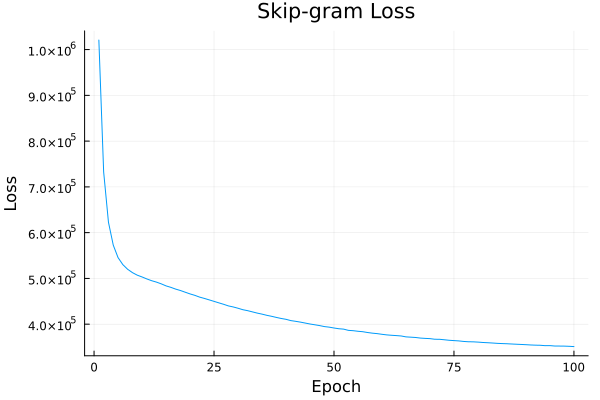

In [9]:
using Plots
plot(skipgram_losses, xlabel="Epoch", ylabel="Loss", title="Skip-gram Loss", legend=false)

# NEW CODE FOR COMPLEX

In [36]:
real_dim = 100
complex_dim = 2
embedding_dim_c = real_dim + complex_dim

102

In [37]:
W, C = init_WC(vocab_size, embedding_dim_c)

([0.009831182035744465 0.010133617859561144 … 0.010073385040224708 0.0037208098069947382; -0.015089846797796633 -0.0021158631872657506 … 0.008677683448604322 0.001623964440468659; … ; 0.02541785194372175 -0.017381106574654075 … -0.00845087807404985 0.012050748437325698; 0.004233734713903868 -0.0036151684833319966 … -0.0037084672745156247 -0.009748219048637588], [-0.0012832699568290256 -0.01089632758609613 … 0.0060325499127969594 -0.004127141039327679; -0.009750560135289348 0.015398358236541003 … -0.011492815957151138 0.008814054377283451; … ; 0.002980171261532064 -0.012842179465248196 … -0.0021285767275842997 -0.0015360002316947281; -0.015495612100733799 -0.01428812727735544 … 0.016217436158708024 0.003437884708973698])

In [41]:

function complex_score(u::AbstractVector, v::AbstractVector)
    d  = length(u) - 2

    # real-block dot product
    base = dot(view(u, 1:d), view(v, 1:d))

    # complex slot
    ru, iu = u[d+1], u[d+2]
    rv, iv = v[d+1], v[d+2]

    complex = ru*rv + iu*iv           # Re(conj(z_u) * z_v)
    return base + complex
end


complex_score (generic function with 1 method)

In [42]:

function train_skipgram_c(corpus, vocab_size, embedding_dim_c;
                        window_size=2, epochs=100, lr=0.1, min_lr=1e-4,
                        neg_samples=5, decay=0.97)

    W, C = init_WC(vocab_size, embedding_dim_c)
    losses = Float64[]

    for epoch in 1:epochs
        total_loss = 0.0
        lr_epoch = max(lr * decay^(epoch - 1), min_lr)

        for sentence in corpus
            for i in 1:length(sentence)
                center = sentence[i]
                context_range = max(1, i - window_size):min(length(sentence), i + window_size)
                for j in context_range
                    if i == j
                        continue
                    end
                    context = sentence[j]

                    # Positive pair
                    score = complex_score(W[center, :], C[context, :]) # score = dot(W[center, :], C[context, :])
                    pos_loss = -log(sigmoid(score))
                    grad = sigmoid(score) - 1
                    W[center, :] .-= lr_epoch * grad * C[context, :]
                    C[context, :] .-= lr_epoch * grad * W[center, :]
                    total_loss += pos_loss

                    # Negative samples
                    for neg in get_negative_samples(vocab_size, context, neg_samples)
                        score = complex_score(W[center, :], C[neg, :]) # score = dot(W[center, :], C[neg, :])
                        neg_loss = -log(sigmoid(-score))
                        grad = sigmoid(score)
                        W[center, :] .-= lr_epoch * grad * C[neg, :]
                        C[neg, :] .-= lr_epoch * grad * W[center, :]
                        total_loss += neg_loss
                    end
                end
            end
        end
        push!(losses, total_loss)
        println("Epoch $epoch | Loss: $total_loss | LR: $lr_epoch")
    end

    return W + C, losses
end

# Train skipgram model
skipgram_embeddings_c, skipgram_losses_c = train_skipgram_c(corpus_to_idx, vocab_size, embedding_dim_c,
    window_size=5, epochs=100, lr=0.01, min_lr=1e-5, decay=0.97,
    neg_samples=5)

Epoch 1 | Loss: 1.020782723476861e6 | LR: 0.01
Epoch 2 | Loss: 732196.4304244606 | LR: 0.0097
Epoch 3 | Loss: 623252.5571471517 | LR: 0.009408999999999999
Epoch 4 | Loss: 572513.5101922413 | LR: 0.00912673
Epoch 5 | Loss: 545681.6311128609 | LR: 0.008852928099999999
Epoch 6 | Loss: 529928.059997949 | LR: 0.008587340257
Epoch 7 | Loss: 519967.5144129794 | LR: 0.008329720049289998
Epoch 8 | Loss: 512957.3671250967 | LR: 0.008079828447811297
Epoch 9 | Loss: 507678.1461243426 | LR: 0.007837433594376959
Epoch 10 | Loss: 503074.35144677846 | LR: 0.007602310586545651
Epoch 11 | Loss: 498664.7959572531 | LR: 0.007374241268949281
Epoch 12 | Loss: 494511.1634926192 | LR: 0.007153014030880802
Epoch 13 | Loss: 491112.6092632164 | LR: 0.006938423609954378
Epoch 14 | Loss: 487684.044361163 | LR: 0.006730270901655747
Epoch 15 | Loss: 483498.04532335186 | LR: 0.006528362774606074
Epoch 16 | Loss: 480470.4716773885 | LR: 0.006332511891367892
Epoch 17 | Loss: 476164.66262425063 | LR: 0.00614253653462685

([0.03546109112615253 -0.13082209031416478 … -1.385582643866209 -0.2694601875690569; 0.26476208779132127 0.25008527667069524 … -0.48540499848410323 -0.44942765608155444; … ; -0.07674915625694839 -0.24985673936926295 … 0.14524704943482813 0.11097674498361955; -0.008056660281907652 -0.07078994169737804 … 0.13615808980204996 -0.06245829828100421], [1.020782723476861e6, 732196.4304244606, 623252.5571471517, 572513.5101922413, 545681.6311128609, 529928.059997949, 519967.5144129794, 512957.3671250967, 507678.1461243426, 503074.35144677846  …  353201.36243933236, 352040.883028402, 352521.9535477557, 351961.0418322921, 351460.21168514265, 351485.6344110057, 350718.5782476839, 350594.6496983992, 350585.36673205555, 349921.1927341702])

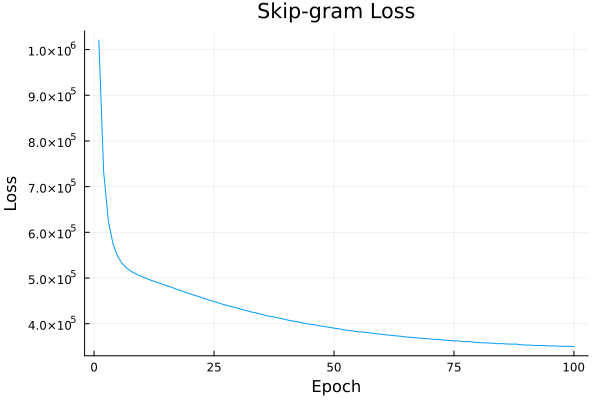

In [43]:
plot(skipgram_losses_c, xlabel="Epoch", ylabel="Loss", title="Skip-gram Loss", legend=false)